In [1]:
# Parameters of the genetic algorithm
mutation_prob = 0.025 # mutation percentage
N = 10 # Population size
S = int(N*0.25) # Sampling size for mutation and crossing 
G = 10 # Number of cycles

In [2]:
DIM = 100  # Number of bits in the bit strings (i.e. the "models").
NOISE_STDEV = 0.01  # Standard deviation of the simulated training noise.

class Model(object): 
    def __init__(self):
        self.arch = None
        self.accuracy = None
    
    def __str__(self):
        return '{0:b}'.format(self.arch)

def train_and_eval(arch):
    accuracy =  float(_sum_bits(arch)) / float(DIM)
    accuracy += random.gauss(mu=0.0, sigma=NOISE_STDEV)
    accuracy = 0.0 if accuracy < 0.0 else accuracy
    accuracy = 1.0 if accuracy > 1.0 else accuracy
    return accuracy

def _sum_bits(arch):
    total = 0
    for _ in range(DIM):
        total += arch & 1
        arch = (arch >> 1)
    return total

In [3]:
import random

def random_architecture():
    return random.randint(0, 2**DIM - 1)

def mutate_arch(parent_arch):
    child_arch = parent_arch
    for i in range(int(mutation_prob*DIM)):
    # Flip the bit at a random position in `child_arch`.
        child_arch = child_arch ^ (1 << random.randint(0, DIM - 1))
  
    return child_arch
x = random_architecture()
mx = mutate_arch(x)
print(bin(x), len(bin(x)))
print(bin(mx), len(bin(mx)))
print(x, mx)

0b100000011010011110110110001101110001111111111000001000000100100100001011111010100101001101101101111 101
0b100000011010011110110110001101110101111111111000001000000100100100001011111010100101001111101101111 101
321010538931228719797052283759 321010538968122207944471388015


In [4]:
def crossing_arch(parent_arch1, parent_arch2):
    str1 = bin(parent_arch1)[2:]
    str2 = bin(parent_arch2)[2:]
    while len(str1) < DIM:
        str1 = '0' + str1
    while len(str2) < DIM:
        str2 = '0' + str2
    pos1 = random.randint(0,DIM)
    pos2 = random.randint(0,DIM)
    if pos2 < pos1:
        temp = pos1
        pos1 = pos2
        pos2 = temp
    
    new_str1 = str1[:pos1] + str2[pos1:pos2] + str1[pos2:]
    new_str2 = str2[:pos1] + str1[pos1:pos2] + str2[pos2:]
    
    return int(new_str1, 2), int(new_str2, 2)

x = random_architecture()
y = random_architecture()
z,w = crossing_arch(x,y)
print(x,y)
print(z,w)

405139398778341452580196003781 490784136840279693810745461358
405366274129588454660897845189 490557261489032691730043619950


In [5]:
def crossing_and_mutate_sample(sample):
    parent1 = max(sample, key=lambda i: i.accuracy)
    parent2 = min(sample, key=lambda i: i.accuracy)
    
    # Crossover
    child1 = Model()
    child2 = Model()
    child1.arch, child2.arch = crossing_arch(parent1.arch, parent2.arch) 
    child1.accuracy = train_and_eval(child1.arch)
    child2.accuracy = train_and_eval(child2.arch)
    
    # Mutation of best in sample
    child3 = Model()
    child3.arch = mutate_arch(parent1.arch)
    child3.accuracy = train_and_eval(child3.arch)
    
    competitors = [parent1, parent2, child1, child2, child3]
    best1 = max(competitors, key=lambda i: i.accuracy)
    competitors.remove(best1)
    best2 = max(competitors, key=lambda i: i.accuracy)
    
    # Competition
    return best1#, best2

In [6]:
x = Model()
y = Model()
x.arch = random_architecture()
y.arch = random_architecture()
x.accuracy = train_and_eval(x.arch)
y.accuracy = train_and_eval(y.arch)
sample = [x,y]
z = crossing_and_mutate_sample(sample)

print(x.accuracy, y.accuracy)
print(z.accuracy)

0.496916807256511 0.4598714678298836
0.5170842848372629


In [7]:
def order_by_accuracy(population):
    temp = Model()
    for i in range(len(population)):
        for j in range(len(population)):
            if population[j].accuracy < population[i].accuracy:
                temp = population[i]
                population[i] = population[j]
                population[j] = temp
    return population
                
#def order(arr):
#    for i in range(len(arr)):
#        for j in range(len(arr)):
#            if arr[j] < arr[i]:
#                temp = arr[i]
#                arr[i] = arr[j]
#                arr[j] = temp
#    return arr
#order([-2,1,3, 12, 2,3,5,])

In [18]:
# The GA itself
def simple_crossing_ga(cycles, population_size, sample_size):

    population = []
    history = []  # Not used by the algorithm, only used to report results.

    # Initialize the population with random models.
    while len(population) < population_size:
        model = Model()
        model.arch = random_architecture()
        model.accuracy = train_and_eval(model.arch)
        population.append(model)
        history.append(model)
    population = order_by_accuracy(population)

    # Carry out evolution in cycles. In a cycle: a sample is taken, 
    # the best in the sample is mutated and the best and the worst a crossed over; 
    # we remove the 
    while len(history) < cycles:
        # Sample randomly chosen models from the current population.
        sample = []
        while len(sample) < sample_size:
            # Inefficient, but written this way for clarity. In the case of neural
            # nets, the efficiency of this line is irrelevant because training neural
            # nets is the rate-determining step.
            candidate = random.choice(list(population))
            sample.append(candidate)
    
        child = Model()
        child = crossing_and_mutate_sample(sample)
        
        # Insert child in population preserving the order and removes worse model
        i = 0
        while child.accuracy < population[i].accuracy:
            i += 1
        if i < len(population): 
            population = population[:i] + [child] + population[i:-1]
        history.append(child)
        #print("Cycle ", len(history), " completed")
        # Remove the oldest model.
        #population.popleft()

    return history

In [30]:
history = simple_crossing_ga(cycles = 300, population_size = 100, sample_size = 10)

/home/erick/anaconda3/envs/ml/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/erick/anaconda3/envs/ml/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/erick/anaconda3/envs/ml/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/erick/anaconda3/envs/ml/lib/python3.7/site-pac

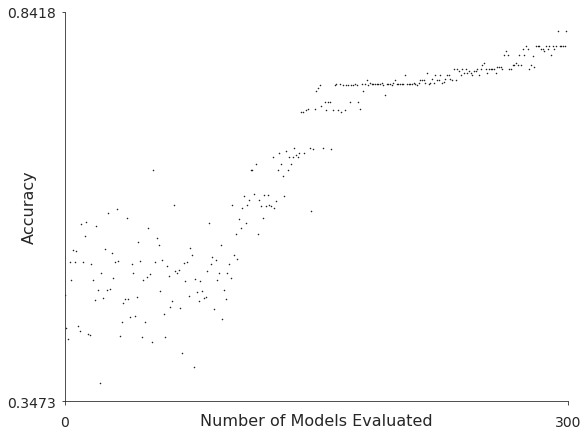

In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set_style('white')
xvalues = range(len(history))
yvalues = [i.accuracy for i in history]
ax = plt.gca()
ax.scatter(
    xvalues, yvalues, marker='.', facecolor=(0.0, 0.0, 0.0),
    edgecolor=(0.0, 0.0, 0.0), linewidth=1, s=1)
ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=2))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_locator(ticker.LinearLocator(numticks=2))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
fig = plt.gcf()
fig.set_size_inches(8, 6)
fig.tight_layout()
ax.tick_params(
    axis='x', which='both', bottom='True', top='False', labelbottom='True',
    labeltop='False', labelsize=14, pad=10)
ax.tick_params(
    axis='y', which='both', left='True', right='False', labelleft='True',
    labelright='False', labelsize=14, pad=5)

plt.xlabel('Number of Models Evaluated', labelpad=-16, fontsize=16)
plt.ylabel('Accuracy', labelpad=-30, fontsize=16)
plt.xlim(0, 300)
sns.despine()